In [2]:
import pandas as pd

report = pd.read_csv('reports/category_table_params.csv')
results = []
for index, row in report[report.Category == 'global_metrics'].transpose().iterrows():
    if index == 'Category':
        continue
    name = index.split('_')[0]
    t = index.split('_')[1][1:]
    r = index.split('_')[2][1:]
    acc = row.values[0]
    results.append({
        'temperature': t,
        'shots': r,
        'accuracy': acc,
        'model': name
    })
df = pd.DataFrame(results)
df['temperature'] = df.temperature.astype('float')
df['shots'] = df.shots.astype('int')


# shots_ranges = []
# for model in df.model:
#     shots = set(df[df.model == model].shots.astype(str))
#     shots_ranges.append((', '.join(shots)))

# df['shot_range'] = shots_ranges

# temperature_ranges = []
# for model in df.model:
#     shots = set(df[df.model == model].temperature.astype(str))
#     temperature_ranges.append((', '.join(shots)))

# df['temperature_ranges'] = temperature_ranges

### Simple table

In [3]:
best_accuracy_df = df.loc[df.groupby('model')['accuracy'].idxmax()]
best_accuracy_df[['model', 'temperature', 'shots', 
                  'accuracy']].sort_values(by='accuracy', ascending=False)

,model,temperature,shots,accuracy
65,claude-3-haiku,0.5,2,0.94
103,gemini-flash-1.5,0.5,2,0.93
96,gpt-4o,0.0,3,0.92
23,claude-3-sonnet,0.5,1,0.91
80,gemini-pro,0.0,3,0.88
16,gpt-4-1106-preview,0.5,2,0.84
71,gpt-3.5-turbo-1106,0.0,3,0.83
92,mixtral-8x7b-instruct,0.5,3,0.65
2,saiga-mistral-7b,0.0,1,0.40
49,gemma,0.5,2,0.18


## Param relations

In [341]:
df_long = report.melt(id_vars='Category', var_name='model_temp_shots', value_name='accuracy')
df_long[['model', 'temperature', 'shots']] = df_long['model_temp_shots'].str.extract(r'(.*)_t([0-9.]+)_r([0-9]+)')
df_long['shots'] = df_long['shots'].astype(int)
df_long['temperature'] = df_long['temperature'].astype(float)
df_long = df_long.drop('model_temp_shots', axis=1)

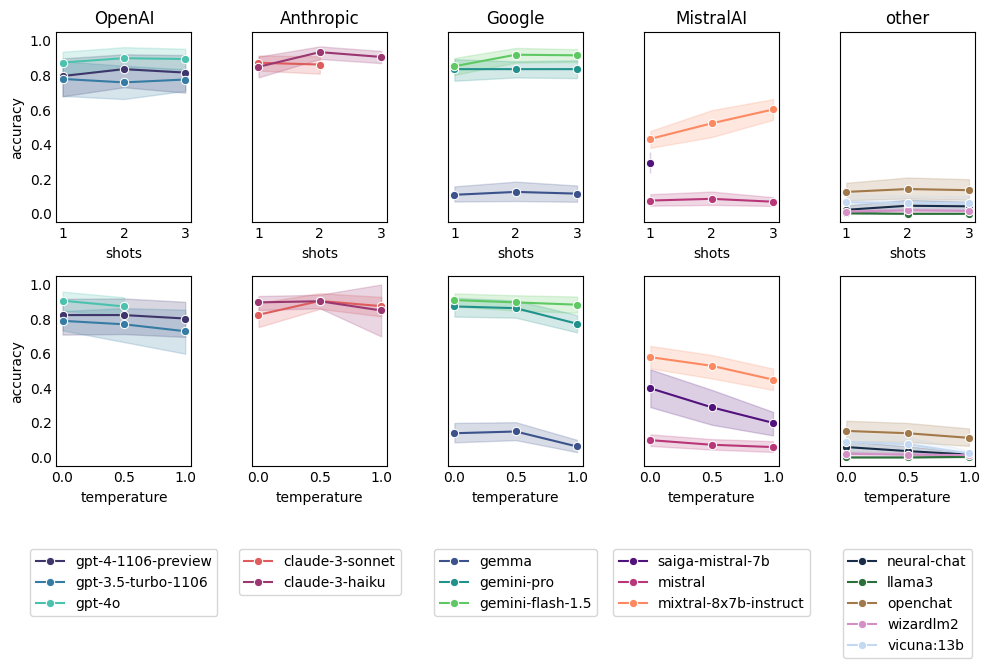

In [342]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


model_groups = {
    'OpenAI': ['gpt-4-1106-preview', 'gpt-3.5-turbo-1106', 'gpt-4o'],
    'Anthropic': ['claude-3-sonnet', 'claude-3-haiku'],
    'Google': ['gemini-pro', 'gemini-flash-1.5', 'gemma'],
    'MistralAI': ['mixtral-8x7b-instruct', 'saiga-mistral-7b', 'mistral'],
    'other': ['openchat', 'vicuna:13b', 'neural-chat', 'wizardlm2', 'llama3']
}
df_long['group'] = df_long.model.apply(lambda x: [group for group, models in model_groups.items() if x in models][0])

palettes = {
    'OpenAI': 'mako',
    'Anthropic': 'flare',
    'Google': 'viridis',
    'MistralAI': 'magma',
    'other': 'cubehelix'

}


num_groups = len(model_groups)
fig, axes = plt.subplots(2, num_groups, figsize=(10, 7), sharex=False, sharey=True)

for index, (group, models) in enumerate(model_groups.items()):
    ax = axes[0, index]
    data = df_long[df_long['group'] == group]
    sns.lineplot(ax=ax, x='shots', y='accuracy', hue='model', data=data, marker='o', palette=palettes[group])
    ax.set_title(f'{group}')    
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.get_legend().remove()


for index, (group, models) in enumerate(model_groups.items()):
    ax = axes[1, index]
    data = df_long[df_long['group'] == group]
    sns.lineplot(ax=ax, x='temperature', y='accuracy', hue='model', data=data, marker='o', palette=palettes[group])
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4))


plt.tight_layout()
plt.show()

## Unrecoverable errors

In [10]:
categories = ['FRACTION',
              'MEASURE',
              'DATE',
              'CARDINAL',
              'TIME',
              'ROMAN',
              'MONEY',
              'DECIMAL',
              'ORDINAL',
              'LETTERS']


critical_data = {}
for index, row in best_accuracy_df.iterrows():
    critical_data[row.model] = {}
    for category in categories:
        pred_path = f'reports/{row.model}/predictions/t{row.temperature}_r{row.shots}_{category}.csv'
        predictions = pd.read_csv(pred_path, sep='\t')
        digit_pred = predictions.response.apply(lambda x: ''.join([symbol for symbol in x if symbol.isdigit()]))
        digit_test = predictions.target.apply(lambda x: ''.join([symbol for symbol in x if symbol.isdigit()]))
        critical = sum(digit_pred != digit_test) / len(digit_test)
        critical_data[row.model][category] = critical

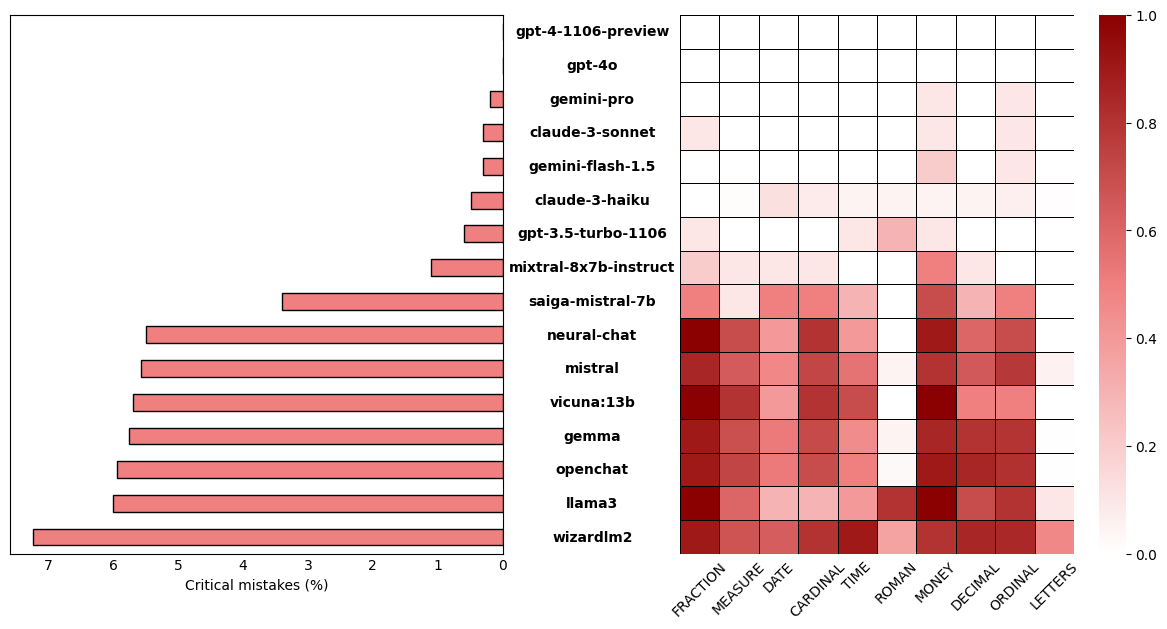

In [315]:
critical_df = pd.DataFrame(critical_data)
sorted_models = critical_df.transpose().mean(axis=1).sort_values().index

fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=False, sharey=False)

critical_df[sorted_models[::-1]].transpose().sum(axis=1).plot.barh(ax=axes[0], color='lightcoral',edgecolor ="black")
cmap=LinearSegmentedColormap.from_list('rg',["w", "lightcoral", "darkred"], N=256) 
sns.heatmap(critical_df[sorted_models].transpose(), annot=False, ax=axes[1], cmap=cmap,  linewidths=0.5, linecolor='black')


axes[0].invert_xaxis()
axes[0].set_yticklabels([])
axes[0].tick_params(axis=u'both', which=u'both', length=0)
axes[0].set_xlabel('Critical mistakes (%)')
# axes[0].set_facecolor('0.9') 


axes[1].tick_params(axis=u'both', which=u'both', length=0)
axes[1].set_yticklabels(sorted_models, fontweight='bold', ha='center', position=(-0.21, 0))
axes[1].set_xlabel('')
axes[1].set_ylabel('')
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)

plt.subplots_adjust(wspace=0.36, hspace=0)
plt.show()


In [12]:
best_accuracy_df['critical_mistakes'] = (pd.DataFrame(critical_data).sum() / 10).values
best_accuracy_df[['model', 'temperature', 'shots', 
                  'accuracy', 'critical_mistakes']].sort_values(by='accuracy', ascending=False)

,model,temperature,shots,accuracy,critical_mistakes
65,claude-3-haiku,0.5,2,0.94,0.048983
103,gemini-flash-1.5,0.5,2,0.93,0.030000
96,gpt-4o,0.0,3,0.92,0.000000
23,claude-3-sonnet,0.5,1,0.91,0.030000
80,gemini-pro,0.0,3,0.88,0.020000
16,gpt-4-1106-preview,0.5,2,0.84,0.000000
71,gpt-3.5-turbo-1106,0.0,3,0.83,0.060000
92,mixtral-8x7b-instruct,0.5,3,0.65,0.110000
2,saiga-mistral-7b,0.0,1,0.40,0.340000
49,gemma,0.5,2,0.18,0.576362


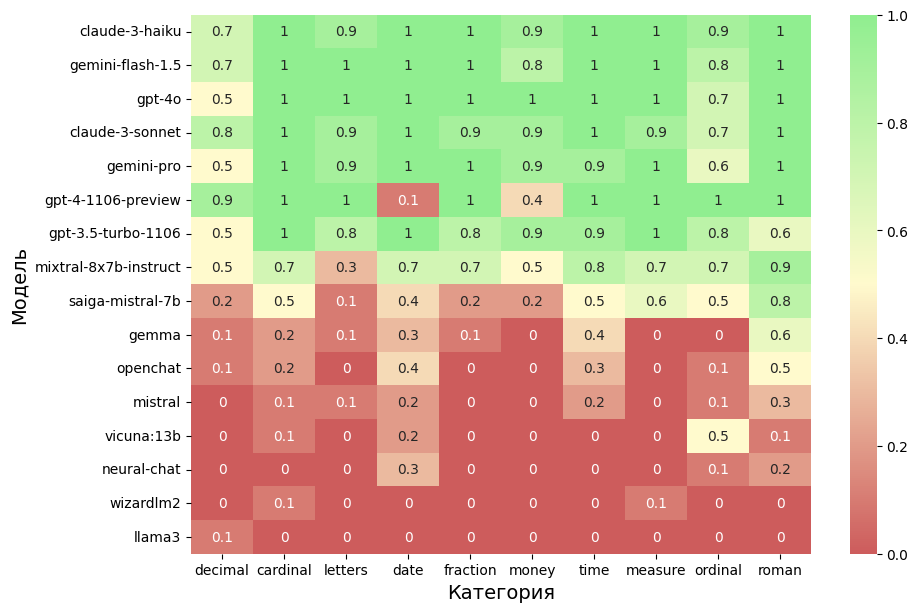

In [443]:
from  matplotlib.colors import LinearSegmentedColormap
# cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
cmap=LinearSegmentedColormap.from_list('rg', list(zip([0, 0.5, 1], ["indianred", "lemonchiffon", "lightgreen"])), N=256)

best_model_params = best_accuracy_df\
    .sort_values(by='accuracy', ascending=False)\
    .apply(lambda row: f'{row.model}_t{row.temperature}_r{row.shots}', axis=1)\
    .tolist()
best_categories_distr = report[best_model_params]
best_categories_distr.index = [col.lower() for col in report['Category']]
best_categories_distr.columns = [col.split('_')[0] for col in best_categories_distr.columns]

fig, axes = plt.subplots(1, 1, figsize=(10, 7), sharex=False, sharey=True)
sns.heatmap(best_categories_distr.transpose().drop('global_metrics', axis=1), annot=True, cmap=cmap)
axes.set_xlabel('Категория', fontsize=14)
axes.set_ylabel('Модель',  fontsize=14)
plt.show()

In [444]:
best_accuracy_df

,temperature,shots,accuracy,model,critical_mistakes
65,0.5,2,0.94,claude-3-haiku,0.048983
23,0.5,1,0.91,claude-3-sonnet,0.030000
103,0.5,2,0.93,gemini-flash-1.5,0.030000
80,0.0,3,0.88,gemini-pro,0.020000
49,0.5,2,0.18,gemma,0.576362
71,0.0,3,0.83,gpt-3.5-turbo-1106,0.060000
16,0.5,2,0.84,gpt-4-1106-preview,0.000000
96,0.0,3,0.92,gpt-4o,0.000000
27,1.0,1,0.01,llama3,0.600000
39,0.0,1,0.10,mistral,0.557328


In [110]:
# df_long = report.melt(id_vars='Category', var_name='model_temp_shots', value_name='accuracy')
# df_long[['model', 'temperature', 'shots']] = df_long['model_temp_shots'].str.extract(r'(.*)_t([0-9.]+)_r([0-9]+)')
# df_long['shots'] = df_long['shots'].astype(int)
# df_long['temperature'] = df_long['temperature'].astype(float)
# df_long = df_long.drop('model_temp_shots', axis=1)
# df_long = df_long[df_long.Category != 'global_metrics']

In [351]:
global_long_df = df_long[df_long.Category == 'global_metrics']

In [355]:
from pathlib import Path

critical_mistakes_all = []
for index, row in global_long_df.iterrows():
    error_rates = []
    for category in categories:
        pred_path = f'reports/{row.model}/predictions/t{row.temperature}_r{row.shots}_{category}.csv'
        if not Path(pred_path).exists():
            error_rates.append(0)
            continue
        predictions = pd.read_csv(pred_path, sep='\t')
        predictions['response'] = predictions.response.astype(str)
        predictions['target'] = predictions.target.astype(str)
        digit_pred = predictions.response.apply(lambda x: ''.join([symbol for symbol in x if symbol.isdigit()]))
        digit_test = predictions.target.apply(lambda x: ''.join([symbol for symbol in x if symbol.isdigit()]))
        critical = sum(digit_pred != digit_test) / len(digit_test)
        error_rates.append(critical)
    critical_mistakes_all.append(sum(error_rates) / len(error_rates))

global_long_df['critical'] = critical_mistakes_all

/tmp/ipykernel_12200/4224143053.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_long_df['critical'] = critical_mistakes_all


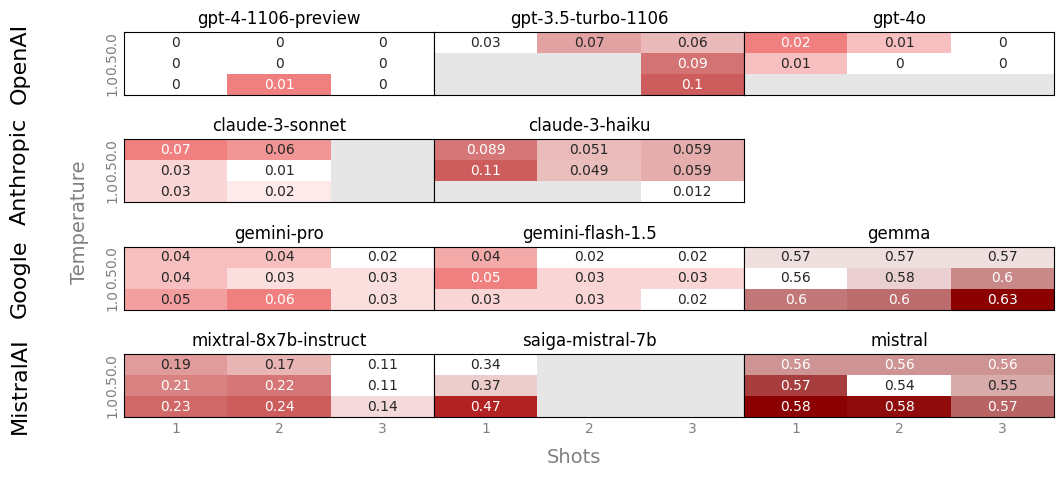

In [439]:
def get_color_limit(maximum):
    if maximum < 0.1:
        return "lightcoral"
    if maximum < 0.3:
        return "indianred"
    if maximum < 0.5:
        return "firebrick"
    return "darkred"

# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
    
fig, axes = plt.subplots(4, 3, figsize=(12, 5), sharex=True, sharey=True)

for group_idx, (group, models) in enumerate(model_groups.items()):
    if group_idx > 3:
        break
    for model_idx, model in enumerate(models):
        pass
        related = global_long_df[global_long_df.model == model][['temperature', 'shots', 'critical']]
        pivoted = related.pivot(index="temperature", columns="shots", values="critical")
        color_limit = get_color_limit(related.critical.max())
        cmap=LinearSegmentedColormap.from_list('rg', list(zip([0, 1], ["w", color_limit])), N=256)
        sns.heatmap(pivoted, annot=True, 
                    ax=axes[group_idx, model_idx], 
                    cmap=cmap,  linewidths=0.0, linecolor='black',
                    cbar=False)
        
        axes[group_idx, model_idx].set_xlabel('')
        axes[group_idx, model_idx].set_ylabel('')
        axes[group_idx, model_idx].tick_params(axis=u'both', which=u'both',length=0, color='grey')
        axes[group_idx, model_idx].set_title(f'{model}')
        axes[group_idx, model_idx].tick_params(axis='x', colors='grey')
        axes[group_idx, model_idx].tick_params(axis='y', colors='grey')


        if model_idx == 0:
            axes[group_idx, model_idx].set_ylabel(f'{group}\n\n\n', fontsize=16)


        for _, spine in axes[group_idx, model_idx].spines.items():
            spine.set_visible(True)
        axes[group_idx, model_idx].set_facecolor('0.9') 

plt.subplots_adjust(wspace=0, hspace=0.7)
fig.supylabel('Temperature', fontsize=14, x=0.08, color='grey')
fig.supxlabel('Shots', fontsize=14, color='grey')
axes[1, 2].set_visible(False)
plt.show()

In [344]:
df_long

,Category,accuracy,model,temperature,shots,group,critical
0,DECIMAL,0.00,saiga-mistral-7b,1.0,1,MistralAI,0.8
1,CARDINAL,0.20,saiga-mistral-7b,1.0,1,MistralAI,0.7
2,LETTERS,0.00,saiga-mistral-7b,1.0,1,MistralAI,0.0
3,DATE,0.30,saiga-mistral-7b,1.0,1,MistralAI,0.7
4,FRACTION,0.10,saiga-mistral-7b,1.0,1,MistralAI,0.7
...,...,...,...,...,...,...,...
1381,TIME,0.10,vicuna:13b,0.5,3,other,0.6
1382,MEASURE,0.00,vicuna:13b,0.5,3,other,0.8
1383,ORDINAL,0.30,vicuna:13b,0.5,3,other,0.6
1384,ROMAN,0.10,vicuna:13b,0.5,3,other,0.0


In [ ]:
critical_data = {}
for index, row in best_accuracy_df.iterrows():
    critical_data[row.model] = {}
    for category in categories:
        pred_path = f'reports/{row.model}/predictions/t{row.temperature}_r{row.shots}_{category}.csv'
        predictions = pd.read_csv(pred_path, sep='\t')
        digit_pred = predictions.response.apply(lambda x: ''.join([symbol for symbol in x if symbol.isdigit()]))
        digit_test = predictions.target.apply(lambda x: ''.join([symbol for symbol in x if symbol.isdigit()]))
        critical = sum(digit_pred != digit_test) / len(digit_test)
        critical_data[row.model][category] = critical

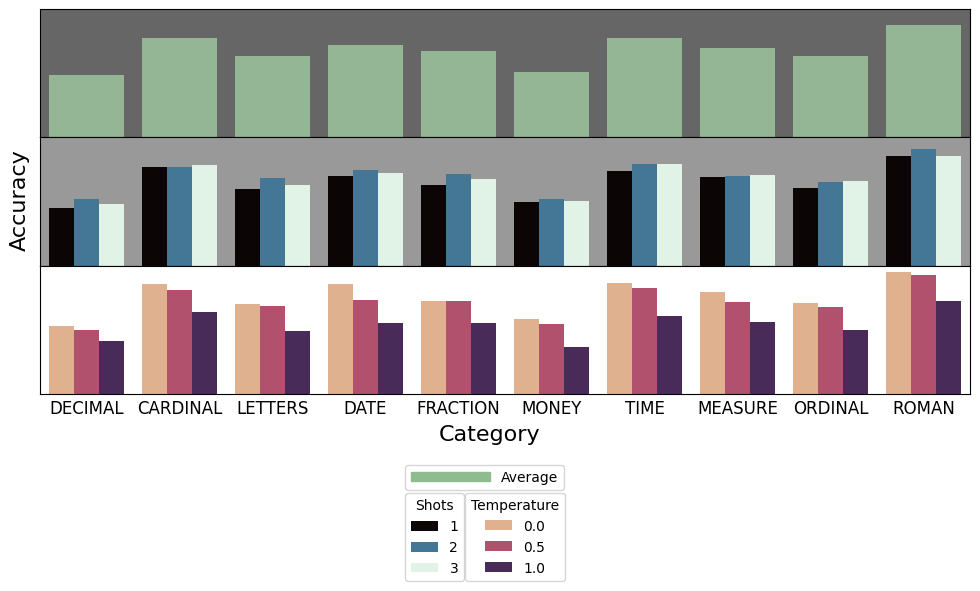

In [236]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=False, sharey=True)


sns.barplot(x='Category', y='accuracy', data=df_long, errorbar=None, ax=axes[0], color='darkseagreen')
axes[0].tick_params(axis=u'both', which=u'both',length=0)
axes[0].set_xticklabels([])
axes[0].set_facecolor('0.4') 
blue_patch = mpatches.Patch(color='darkseagreen', label='Average') 
axes[0].legend(handles=[blue_patch], loc='lower left', bbox_to_anchor=(0.385, -2.8), handlelength=5.7) 
axes[0].set_xlabel('')
axes[0].set_ylabel('')


sns.barplot(x='Category', y='accuracy', hue='shots', data=df_long, errorbar=None, ax=axes[1], palette='mako')
axes[1].legend(loc='lower left', bbox_to_anchor=(0.385, -2.51), title="Shots")
axes[1].tick_params(axis=u'both', which=u'both', length=0)
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_facecolor('0.6') 


sns.barplot(x='Category', y='accuracy', hue='temperature', data=df_long, errorbar=None, ax=axes[2], palette='flare')
axes[2].legend(loc='center left', bbox_to_anchor=(0.45, -1.11), title='Temperature')
axes[2].tick_params(axis=u'both', which=u'both',length=0, labelsize=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')

plt.subplots_adjust(wspace=0, hspace=0)
fig.supylabel('Accuracy', fontsize=16, x=0.1)
fig.supxlabel('Category', fontsize=16)
plt.show()